In [1]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Calling DMRs with modality

This notebooks illustrates how [`modality`](https://modality-docs.biomodal.com/) can call DMRs (differentially methylated regions). The code looks for specific group differences (e.g. healthy versus control, or sex). A brief outline of the code is described below:

1. We divide genome in smaller regions. Two options are available:
 - tiles of fixed length (e.g. 2kb)
 - segmentation based, in which we identify gaps in the genome where there are no CpG within a certain distance (e.g. 500bp) and divide accordingly. This is the default mode.

2. The contexts of each region are summed together to get the total number of methylated and unmethylated counts.

3. We use a logistic regression to model the methylation levels of each region. A DMR is defined as a region with a significant difference in methylation levels between two conditions. This is quantified by a p-value.

4. Based on this p-value, we can decide if the tile is a DMR. We also report a q-value, which is the p-value corrected using the Benjamini-Hochberg method. 

In [2]:
from modality.analysis import call_dmrs
from modality import load_biomodal_dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import seaborn as sns

## Load the data

For the purposes of this demo we can use a duet +modC dataset consisting of 14 Genome in a Bottle (GIAB) samples. The data are publicly available and can be loaded using the [`load_biomodal_dataset()`](https://modality-docs.biomodal.com/modality.html#modality.datasets.load_biomodal_dataset) function. This will pull the dataset and load it in to our session as a [`ContigDataset`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset) object.

The dataset consists of 14 samples, 2 replicates of 7 cell lines. In this notebook we will look for regions of genome that are differentially methylated between two families: the Han mother-father-son trio on one hand, and the Ashkenazi mother-father-son trio on the other hand.

We merge the 2 technical replicates, and we merge the CpGs on the two strands.

In [4]:
ds = load_biomodal_dataset(
    name="giab",
    merge_technical_replicates=True,
    merge_cpgs=True,
    )

In [5]:
ds

ContigDataset(data_vars=Data variables:
    num_c                           (pos, sample_id) uint64 2GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_modc                        (pos, sample_id) uint64 2GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_n                           (pos, sample_id) uint64 2GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_other                       (pos, sample_id) uint64 2GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_total                       (pos, sample_id) uint64 2GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_total_c                     (pos, sample_id) uint64 2GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    Input DNA Quantity (ng/sample)  (sample_id) int64 56B 80 80 80 80 80 80 80
    Protocol Version                (sample_id) object 56B '5-Letter v2.4' .....
    NA_id                           (sample_id) object 56B 'NA12878' ... 'NA2...
    family                          (sample_id) object 56B 'Utah' ... 'Han Ch...
    family_status                   (sample_id) object 56B 'Singleton' ... 'M...
    sex                             (sample_id) object 56B 'Female' ... 'Female'
    tech_replicate_number           (sample_id) int64 56B 1 1 1 1 1 1 1, coords=Coordinates:
    contig                 (pos) <U20 2GB dask.array<chunksize=(40000,), meta=np.ndarray>
    ref_position           (pos) uint32 117MB dask.array<chunksize=(40000,), meta=np.ndarray>
    strand                 (pos) <U1 117MB dask.array<chunksize=(40000,), meta=np.ndarray>
    trinucleotide_context  (pos) uint8 29MB dask.array<chunksize=(40000,), meta=np.ndarray>
  * sample_id              (sample_id) object 56B 'HG001' 'HG002' ... 'HG007'
    group                  (sample_id) object 56B 'HG001' 'HG002' ... 'HG007', attrs={'context': 'CG', 'context_encoding': {'0': 'AAA', '1': 'AAC', '10': 'AGA', '100': 'TAA', '101': 'TAC', '102': 'TAG', '103': 'TAN', '104': 'TAT', '105': 'TCA', '106': 'TCC', '107': 'TCG', '108': 'TCN', '109': 'TCT', '11': 'AGC', '110': 'TGA', '111': 'TGC', '112': 'TGG', '113': 'TGN', '114': 'TGT', '115': 'TNA', '116': 'TNC', '117': 'TNG', '118': 'TNN', '119': 'TNT', '12': 'AGG', '120': 'TTA', '121': 'TTC', '122': 'TTG', '123': 'TTN', '124': 'TTT', '125': 'CG', '13': 'AGN', '14': 'AGT', '15': 'ANA', '16': 'ANC', '17': 'ANG', '18': 'ANN', '19': 'ANT', '2': 'AAG', '20': 'ATA', '21': 'ATC', '22': 'ATG', '23': 'ATN', '24': 'ATT', '25': 'CAA', '255': 'unknown', '26': 'CAC', '27': 'CAG', '28': 'CAN', '29': 'CAT', '3': 'AAN', '30': 'CCA', '31': 'CCC', '32': 'CCG', '33': 'CCN', '34': 'CCT', '35': 'CGA', '36': 'CGC', '37': 'CGG', '38': 'CGN', '39': 'CGT', '4': 'AAT', '40': 'CNA', '41': 'CNC', '42': 'CNG', '43': 'CNN', '44': 'CNT', '45': 'CTA', '46': 'CTC', '47': 'CTG', '48': 'CTN', '49': 'CTT', '5': 'ACA', '50': 'GAA', '51': 'GAC', '52': 'GAG', '53': 'GAN', '54': 'GAT', '55': 'GCA', '56': 'GCC', '57': 'GCG', '58': 'GCN', '59': 'GCT', '6': 'ACC', '60': 'GGA', '61': 'GGC', '62': 'GGG', '63': 'GGN', '64': 'GGT', '65': 'GNA', '66': 'GNC', '67': 'GNG', '68': 'GNN', '69': 'GNT', '7': 'ACG', '70': 'GTA', '71': 'GTC', '72': 'GTG', '73': 'GTN', '74': 'GTT', '75': 'NAA', '76': 'NAC', '77': 'NAG', '78': 'NAN', '79': 'NAT', '8': 'ACN', '80': 'NCA', '81': 'NCC', '82': 'NCG', '83': 'NCN', '84': 'NCT', '85': 'NGA', '86': 'NGC', '87': 'NGG', '88': 'NGN', '89': 'NGT', '9': 'ACT', '90': 'NNA', '91': 'NNC', '92': 'NNG', '93': 'NNN', '94': 'NNT', '95': 'NTA', '96': 'NTC', '97': 'NTG', '98': 'NTN', '99': 'NTT'}, 'contigs': ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM', 'chr1_KI270706v1_rand', 'chr1_KI270707v1_rand', 'chr1_KI270708v1_rand', 'chr1_KI270709v1_rand', 'chr1_KI270710v1_rand', 'chr1_KI270711v1_rand', 'chr1_KI270712v1_rand', 'chr1_KI270713v1_rand', 'chr1_KI270714v1_rand', 'chr2_KI270715v1_

## Select the two families

First, we use the [`select_samples`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.select_samples) method to select only the samples corresponding to the two families of interest (i.e., the families that are not from the HG001/Utah cell line).

In [6]:
ds = ds.select_samples([i for i in ds.sample_id.values if i != "HG001"])

In [7]:
ds

ContigDataset(data_vars=Data variables:
    num_c                           (pos, sample_id) uint64 1GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_modc                        (pos, sample_id) uint64 1GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_n                           (pos, sample_id) uint64 1GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_other                       (pos, sample_id) uint64 1GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_total                       (pos, sample_id) uint64 1GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    num_total_c                     (pos, sample_id) uint64 1GB dask.array<chunksize=(40000, 1), meta=np.ndarray>
    Input DNA Quantity (ng/sample)  (sample_id) int64 48B 80 80 80 80 80 80
    Protocol Version                (sample_id) object 48B '5-Letter v2.4' .....
    NA_id                           (sample_id) object 48B 'NA24385' ... 'NA2...
    family                          (sample_id) object 48B 'Ashkenazi Jewish'...
    family_status                   (sample_id) object 48B 'Son' ... 'Mother'
    sex                             (sample_id) object 48B 'Male' ... 'Female'
    tech_replicate_number           (sample_id) int64 48B 1 1 1 1 1 1, coords=Coordinates:
    contig                 (pos) <U20 2GB dask.array<chunksize=(40000,), meta=np.ndarray>
    ref_position           (pos) uint32 117MB dask.array<chunksize=(40000,), meta=np.ndarray>
    strand                 (pos) <U1 117MB dask.array<chunksize=(40000,), meta=np.ndarray>
    trinucleotide_context  (pos) uint8 29MB dask.array<chunksize=(40000,), meta=np.ndarray>
  * sample_id              (sample_id) object 48B 'HG002' 'HG003' ... 'HG007'
    group                  (sample_id) object 48B 'HG002' 'HG003' ... 'HG007', attrs={'context': 'CG', 'context_encoding': {'0': 'AAA', '1': 'AAC', '10': 'AGA', '100': 'TAA', '101': 'TAC', '102': 'TAG', '103': 'TAN', '104': 'TAT', '105': 'TCA', '106': 'TCC', '107': 'TCG', '108': 'TCN', '109': 'TCT', '11': 'AGC', '110': 'TGA', '111': 'TGC', '112': 'TGG', '113': 'TGN', '114': 'TGT', '115': 'TNA', '116': 'TNC', '117': 'TNG', '118': 'TNN', '119': 'TNT', '12': 'AGG', '120': 'TTA', '121': 'TTC', '122': 'TTG', '123': 'TTN', '124': 'TTT', '125': 'CG', '13': 'AGN', '14': 'AGT', '15': 'ANA', '16': 'ANC', '17': 'ANG', '18': 'ANN', '19': 'ANT', '2': 'AAG', '20': 'ATA', '21': 'ATC', '22': 'ATG', '23': 'ATN', '24': 'ATT', '25': 'CAA', '255': 'unknown', '26': 'CAC', '27': 'CAG', '28': 'CAN', '29': 'CAT', '3': 'AAN', '30': 'CCA', '31': 'CCC', '32': 'CCG', '33': 'CCN', '34': 'CCT', '35': 'CGA', '36': 'CGC', '37': 'CGG', '38': 'CGN', '39': 'CGT', '4': 'AAT', '40': 'CNA', '41': 'CNC', '42': 'CNG', '43': 'CNN', '44': 'CNT', '45': 'CTA', '46': 'CTC', '47': 'CTG', '48': 'CTN', '49': 'CTT', '5': 'ACA', '50': 'GAA', '51': 'GAC', '52': 'GAG', '53': 'GAN', '54': 'GAT', '55': 'GCA', '56': 'GCC', '57': 'GCG', '58': 'GCN', '59': 'GCT', '6': 'ACC', '60': 'GGA', '61': 'GGC', '62': 'GGG', '63': 'GGN', '64': 'GGT', '65': 'GNA', '66': 'GNC', '67': 'GNG', '68': 'GNN', '69': 'GNT', '7': 'ACG', '70': 'GTA', '71': 'GTC', '72': 'GTG', '73': 'GTN', '74': 'GTT', '75': 'NAA', '76': 'NAC', '77': 'NAG', '78': 'NAN', '79': 'NAT', '8': 'ACN', '80': 'NCA', '81': 'NCC', '82': 'NCG', '83': 'NCN', '84': 'NCT', '85': 'NGA', '86': 'NGC', '87': 'NGG', '88': 'NGN', '89': 'NGT', '9': 'ACT', '90': 'NNA', '91': 'NNC', '92': 'NNG', '93': 'NNN', '94': 'NNT', '95': 'NTA', '96': 'NTC', '97': 'NTG', '98': 'NTN', '99': 'NTT'}, 'contigs': ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM', 'chr1_KI270706v1_rand', 'chr1_KI270707v1_rand', 'chr1_KI270708v1_rand', 'chr1_KI270709v1_rand', 'chr1_KI270710v1_rand', 'chr1_KI270711v1_rand', 'chr1_KI270712v1_rand', 'chr1_KI270713v1_rand', 'chr1_KI270714v1_rand', 'chr2_KI270715v1_rand', 'ch

## Restrict to chromosome 1

In this notebook, we will look for DMRs on a subset of the whole genome, here chromosome 1.

In [8]:
substore = ds["chr1"].copy()

## Filter by coverage

It is good practice to remove sites of low coverage before calling DMRs. This can be done with the [`subset_bycoverage`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.subset_bycoverage) method of the ContigDataset. Here we call it with the `method="any"`, which removes a position if ay of the samples have a coverage strictly lower than min_coverage at that CpG context. Other options are `"all"` and `"mean"`. 

In [9]:
substore = substore.subset_bycoverage(min_coverage=5, method="any")

## Call DMRs

Now we can call DMRs using the [`call_dmrs`](https://modality-docs.biomodal.com/modality.html#modality.dmr.call_dmrs) function. We need to specify the [`ContigDataset`](https://modality-docs.biomodal.com/) object we are going to use (here `substore`), as well as the count variables (here `num_modc` and `num_total_c`) and the condition (here we look for DMRs across two different families, so we set use `family`). 

Finally, [`call_dmrs`](https://modality-docs.biomodal.com/modality.html#modality.dmr.call_dmrs) needs to know the regions where to look for DMRs:
- We use the default mode, which is to pre-segment the CpGs, creating a new region every time two consecutive CpGs are separated by a distance larger than `presegment_threshold` (here we use the default `presegment_threshold` of 500bp). This determines the regions in which `modality` is going to look for DMRs.
- Note we could instead pass a `ranges` argument, which can either be an integer (e.g. `ranges=2000` will divide the genome in tiles of size 2kbp), or an actual set of genomic ranges. If such object is provided, `modality` will call DMRs on those ranges. This object should be a [`pyranges`](https://pyranges.readthedocs.io/en/latest/index.html) object. If you have a set of genomic ranges as a bed file, you can for instance use [`ranges = pr.read_bed(path_to_bedfile)`](https://pyranges.readthedocs.io/en/latest/autoapi/pyranges/readers/index.html#module-pyranges.readers) and pass it to [`call_dmrs`](https://modality-docs.biomodal.com/modality.html#modality.dmr.call_dmrs).

For this dataset, it takes about 1 minutes to call DMRs on chromosome 1 on a MacBook Pro M2.

Note that you don't have to restrict to one chromosome at a time. You can use [`call_dmrs`](https://modality-docs.biomodal.com/modality.html#modality.dmr.call_dmrs) on your [`ContigDataset`](https://modality-docs.biomodal.com/) `ds`. 

In [10]:
substore

ContigDataset(data_vars=Data variables:
    num_c                           (pos, sample_id) uint64 108MB dask.array<chunksize=(40000, 6), meta=np.ndarray>
    num_modc                        (pos, sample_id) uint64 108MB dask.array<chunksize=(40000, 6), meta=np.ndarray>
    num_n                           (pos, sample_id) uint64 108MB dask.array<chunksize=(40000, 6), meta=np.ndarray>
    num_other                       (pos, sample_id) uint64 108MB dask.array<chunksize=(40000, 6), meta=np.ndarray>
    num_total                       (pos, sample_id) uint64 108MB dask.array<chunksize=(40000, 6), meta=np.ndarray>
    num_total_c                     (pos, sample_id) uint64 108MB dask.array<chunksize=(40000, 6), meta=np.ndarray>
    Input DNA Quantity (ng/sample)  (sample_id) int64 48B 80 80 80 80 80 80
    Protocol Version                (sample_id) object 48B '5-Letter v2.4' .....
    NA_id                           (sample_id) object 48B 'NA24385' ... 'NA2...
    family                          (sample_id) object 48B 'Ashkenazi Jewish'...
    family_status                   (sample_id) object 48B 'Son' ... 'Mother'
    sex                             (sample_id) object 48B 'Male' ... 'Female'
    tech_replicate_number           (sample_id) int64 48B 1 1 1 1 1 1, coords=Coordinates:
  * sample_id              (sample_id) object 48B 'HG002' 'HG003' ... 'HG007'
    group                  (sample_id) object 48B 'HG002' 'HG003' ... 'HG007'
    contig                 (pos) <U20 179MB dask.array<chunksize=(40000,), meta=np.ndarray>
    ref_position           (pos) uint32 9MB dask.array<chunksize=(40000,), meta=np.ndarray>
    strand                 (pos) <U1 9MB dask.array<chunksize=(40000,), meta=np.ndarray>
    trinucleotide_context  (pos) uint8 2MB dask.array<chunksize=(40000,), meta=np.ndarray>, attrs={'context': 'CG', 'context_encoding': {'0': 'AAA', '1': 'AAC', '10': 'AGA', '100': 'TAA', '101': 'TAC', '102': 'TAG', '103': 'TAN', '104': 'TAT', '105': 'TCA', '106': 'TCC', '107': 'TCG', '108': 'TCN', '109': 'TCT', '11': 'AGC', '110': 'TGA', '111': 'TGC', '112': 'TGG', '113': 'TGN', '114': 'TGT', '115': 'TNA', '116': 'TNC', '117': 'TNG', '118': 'TNN', '119': 'TNT', '12': 'AGG', '120': 'TTA', '121': 'TTC', '122': 'TTG', '123': 'TTN', '124': 'TTT', '125': 'CG', '13': 'AGN', '14': 'AGT', '15': 'ANA', '16': 'ANC', '17': 'ANG', '18': 'ANN', '19': 'ANT', '2': 'AAG', '20': 'ATA', '21': 'ATC', '22': 'ATG', '23': 'ATN', '24': 'ATT', '25': 'CAA', '255': 'unknown', '26': 'CAC', '27': 'CAG', '28': 'CAN', '29': 'CAT', '3': 'AAN', '30': 'CCA', '31': 'CCC', '32': 'CCG', '33': 'CCN', '34': 'CCT', '35': 'CGA', '36': 'CGC', '37': 'CGG', '38': 'CGN', '39': 'CGT', '4': 'AAT', '40': 'CNA', '41': 'CNC', '42': 'CNG', '43': 'CNN', '44': 'CNT', '45': 'CTA', '46': 'CTC', '47': 'CTG', '48': 'CTN', '49': 'CTT', '5': 'ACA', '50': 'GAA', '51': 'GAC', '52': 'GAG', '53': 'GAN', '54': 'GAT', '55': 'GCA', '56': 'GCC', '57': 'GCG', '58': 'GCN', '59': 'GCT', '6': 'ACC', '60': 'GGA', '61': 'GGC', '62': 'GGG', '63': 'GGN', '64': 'GGT', '65': 'GNA', '66': 'GNC', '67': 'GNG', '68': 'GNN', '69': 'GNT', '7': 'ACG', '70': 'GTA', '71': 'GTC', '72': 'GTG', '73': 'GTN', '74': 'GTT', '75': 'NAA', '76': 'NAC', '77': 'NAG', '78': 'NAN', '79': 'NAT', '8': 'ACN', '80': 'NCA', '81': 'NCC', '82': 'NCG', '83': 'NCN', '84': 'NCT', '85': 'NGA', '86': 'NGC', '87': 'NGG', '88': 'NGN', '89': 'NGT', '9': 'ACT', '90': 'NNA', '91': 'NNC', '92': 'NNG', '93': 'NNN', '94': 'NNT', '95': 'NTA', '96': 'NTC', '97': 'NTG', '98': 'NTN', '99': 'NTT'}, 'contigs': ['chr1'], 'coordinate_basis': 0, 'description': 'A +modC dataset of human Genome in a bottle (GIAB) samples.\nThese data were generated by biomodal using a commercial kit.\n\nEach of the seven GIAB samples were sequenced on a single lane of a NovaSeq S4 flowcell.\nTwo technical replicates are available for each sample.', 'fasta_path': 'GRCh38Decoy.fa', 'input_path': ['CEG1530-EL01-A1200-001.genome.GRCh38Decoy_primary_assembly.dedup.bam', 'CEG15

Now we are ready to [call DMRs](https://modality-docs.biomodal.com/modality.html#modality.dmr.call_dmrs).

In [11]:
dmr_regions = call_dmrs(
    ds=substore,
    count_array_name="num_modc",
    total_counts_name="num_total_c",
    condition_array_name="family",
    presegment_threshold=500,
    condition_order=["Ashkenazi Jewish", "Han Chinese"],
    as_pyranges=True,
)

The output `dmr_regions` is a dataframe containing the following columns:
- the chromosome, start, end (zero-based) of the region
- the number of contexts in the region
- the mean coverage of the region
- the mean methylation fraction of each group
- the methylation fold change `(mean(group_2)/mean(group_1))`
- the methylation difference `(mean(group_2)-mean(group_1))`
- the test statistic, in our case a Wald test
- the p-value associated with the significance of the coefficient of the logistic regression associated with the group
- the q-value (Benjamini-Hochberg corrected p-value)

Note that we could also ouptut a `pandas` Dataframe instead of a `pyranges` one by setting `as_pyranges=False` in the `call_dmrs` function.

In [12]:
dmr_regions.head()

+--------------+-----------+-----------+----------------+-------+
| Chromosome   |     Start |       End |   num_contexts | +8    |
| (category)   |   (int64) |   (int64) |        (int64) | ...   |
|--------------+-----------+-----------+----------------+-------|
| chr1         |     10578 |     10816 |             50 | ...   |
| chr1         |     14652 |     14791 |              9 | ...   |
| chr1         |     16138 |     16869 |              8 | ...   |
| chr1         |     17377 |     17613 |             10 | ...   |
| chr1         |     19159 |     19322 |              9 | ...   |
| chr1         |     29271 |     29435 |             25 | ...   |
| chr1         |    102932 |    103249 |              8 | ...   |
| chr1         |    108774 |    109575 |              6 | ...   |
+--------------+-----------+-----------+----------------+-------+
Unstranded PyRanges object has 8 rows and 12 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
8 hidden columns: mean_coverage, mean_mod_group_1, mean_mod_group_2, ... (+ 5 more.)

Even if you kept the [`pyranges`](https://pyranges.readthedocs.io/en/latest/index.html) object as the default type of the output, it is straightforward to convert this object to a `pandas` dataframe if we want:

In [13]:
dmr_regions = dmr_regions.df

It is also useful to associate a slice in the format "Chromosome:Start-End" to the dataframe, since our ContigDataset object can be sliced using such string. This will come in handy later on in this notebook when we plot DMRs.

In [14]:
dmr_regions["Slice"] = dmr_regions.apply(
    lambda row: f"{row['Chromosome']}:{row['Start']}-{row['End']}", axis=1
)    
dmr_regions.head()

Chromosome  Start    End  num_contexts  mean_coverage  mean_mod_group_1  \
0       chr1  10578  10816            50      28.973333          0.966083   
1       chr1  14652  14791             9      70.907407          0.917142   
2       chr1  16138  16869             8      81.333333          0.831444   
3       chr1  17377  17613            10     129.400000          0.960567   
4       chr1  19159  19322             9      63.685185          0.921850   

   mean_mod_group_2  mod_fold_change  mod_difference  test_statistic  \
0          0.924386         0.956839       -0.041697       60.001180   
1          0.934554         1.018985        0.017412        2.874834   
2          0.841313         1.011870        0.009869        1.169600   
3          0.936319         0.974757       -0.024247       22.613622   
4          0.918903         0.996804       -0.002946        0.011737   

     dmr_pvalue    dmr_qvalue             Slice  
0  9.480050e-15  3.337637e-14  chr1:10578-10816  
1  8.997427e-02  1.071010e-01  chr1:14652-14791  
2  2.794835e-01  3.111446e-01  chr1:16138-16869  
3  1.980753e-06  3.656151e-06  chr1:17377-17613  
4  9.137286e-01  9.236813e-01  chr1:19159-19322

## Differentially Methylated Cytosines

Instead of calling DMRs, you may be interested to know if your individual cytosines are differentially methyated or not (so called DMC's). 

In principle you could call DMCs genome-wide, but in practice it involves running one logistic regression per context. This task is time and memory intensive, and is not recommended. Instead, we can focus a small region of interest, for instance a gene or an enhancer, and look at differentially methylated contexts for this region only.

Let's look at the GBA1 gene, associated with Gaucher disease, a genetic disease particularly common in the Ashkenazi population. The gene is on the negative strand of chr1, between positions 155234451 and 155244698 (human reference hg38). We can select this particular region in our dataset by using a slice string formatted as "Chromosome:Start-End". So for our particular gene, we would do:

In [15]:
ds["chr1:155234451-155244698"]

ContigDataset(data_vars=Data variables:
    num_c                           (pos, sample_id) uint64 9kB dask.array<chunksize=(196, 1), meta=np.ndarray>
    num_modc                        (pos, sample_id) uint64 9kB dask.array<chunksize=(196, 1), meta=np.ndarray>
    num_n                           (pos, sample_id) uint64 9kB dask.array<chunksize=(196, 1), meta=np.ndarray>
    num_other                       (pos, sample_id) uint64 9kB dask.array<chunksize=(196, 1), meta=np.ndarray>
    num_total                       (pos, sample_id) uint64 9kB dask.array<chunksize=(196, 1), meta=np.ndarray>
    num_total_c                     (pos, sample_id) uint64 9kB dask.array<chunksize=(196, 1), meta=np.ndarray>
    Input DNA Quantity (ng/sample)  (sample_id) int64 48B 80 80 80 80 80 80
    Protocol Version                (sample_id) object 48B '5-Letter v2.4' .....
    NA_id                           (sample_id) object 48B 'NA24385' ... 'NA2...
    family                          (sample_id) object 48B 'Ashkenazi Jewish'...
    family_status                   (sample_id) object 48B 'Son' ... 'Mother'
    sex                             (sample_id) object 48B 'Male' ... 'Female'
    tech_replicate_number           (sample_id) int64 48B 1 1 1 1 1 1, coords=Coordinates:
    contig                 (pos) <U20 16kB dask.array<chunksize=(196,), meta=np.ndarray>
    ref_position           (pos) uint32 784B dask.array<chunksize=(196,), meta=np.ndarray>
    strand                 (pos) <U1 784B dask.array<chunksize=(196,), meta=np.ndarray>
    trinucleotide_context  (pos) uint8 196B dask.array<chunksize=(196,), meta=np.ndarray>
  * sample_id              (sample_id) object 48B 'HG002' 'HG003' ... 'HG007'
    group                  (sample_id) object 48B 'HG002' 'HG003' ... 'HG007', attrs={'context': 'CG', 'context_encoding': {'0': 'AAA', '1': 'AAC', '10': 'AGA', '100': 'TAA', '101': 'TAC', '102': 'TAG', '103': 'TAN', '104': 'TAT', '105': 'TCA', '106': 'TCC', '107': 'TCG', '108': 'TCN', '109': 'TCT', '11': 'AGC', '110': 'TGA', '111': 'TGC', '112': 'TGG', '113': 'TGN', '114': 'TGT', '115': 'TNA', '116': 'TNC', '117': 'TNG', '118': 'TNN', '119': 'TNT', '12': 'AGG', '120': 'TTA', '121': 'TTC', '122': 'TTG', '123': 'TTN', '124': 'TTT', '125': 'CG', '13': 'AGN', '14': 'AGT', '15': 'ANA', '16': 'ANC', '17': 'ANG', '18': 'ANN', '19': 'ANT', '2': 'AAG', '20': 'ATA', '21': 'ATC', '22': 'ATG', '23': 'ATN', '24': 'ATT', '25': 'CAA', '255': 'unknown', '26': 'CAC', '27': 'CAG', '28': 'CAN', '29': 'CAT', '3': 'AAN', '30': 'CCA', '31': 'CCC', '32': 'CCG', '33': 'CCN', '34': 'CCT', '35': 'CGA', '36': 'CGC', '37': 'CGG', '38': 'CGN', '39': 'CGT', '4': 'AAT', '40': 'CNA', '41': 'CNC', '42': 'CNG', '43': 'CNN', '44': 'CNT', '45': 'CTA', '46': 'CTC', '47': 'CTG', '48': 'CTN', '49': 'CTT', '5': 'ACA', '50': 'GAA', '51': 'GAC', '52': 'GAG', '53': 'GAN', '54': 'GAT', '55': 'GCA', '56': 'GCC', '57': 'GCG', '58': 'GCN', '59': 'GCT', '6': 'ACC', '60': 'GGA', '61': 'GGC', '62': 'GGG', '63': 'GGN', '64': 'GGT', '65': 'GNA', '66': 'GNC', '67': 'GNG', '68': 'GNN', '69': 'GNT', '7': 'ACG', '70': 'GTA', '71': 'GTC', '72': 'GTG', '73': 'GTN', '74': 'GTT', '75': 'NAA', '76': 'NAC', '77': 'NAG', '78': 'NAN', '79': 'NAT', '8': 'ACN', '80': 'NCA', '81': 'NCC', '82': 'NCG', '83': 'NCN', '84': 'NCT', '85': 'NGA', '86': 'NGC', '87': 'NGG', '88': 'NGN', '89': 'NGT', '9': 'ACT', '90': 'NNA', '91': 'NNC', '92': 'NNG', '93': 'NNN', '94': 'NNT', '95': 'NTA', '96': 'NTC', '97': 'NTG', '98': 'NTN', '99': 'NTT'}, 'contigs': ['chr1'], 'coordinate_basis': 0, 'description': 'A +modC dataset of human Genome in a bottle (GIAB) samples.\nThese data were generated by biomodal using a commercial kit.\n\nEach of the seven GIAB samples were sequenced on a single lane of a NovaSeq S4 flowcell.\nTwo technical replicates are available for each sample.', 'fasta_path': 'GRCh38Decoy.fa', 'input_path': ['CEG1530-EL01-A1200-001.genome.GRCh38Decoy_primary_assembly.dedup.bam', 'CEG1530-EL01-A1200-004.genome.GRCh3

Let's look at DMCs in this gene. In order to achieve this, we run the `call_dmrs` function with the `ranges=1` parameter. This creates ranges of size 1bp, so each context becomes its own genomic range on which we can call differential methylation.

In [16]:
dmc_calls = call_dmrs(
    ds=ds["chr1:155234451-155244698"],
    count_array_name="num_modc",
    total_counts_name="num_total_c",
    condition_array_name="family",
    condition_order=["Ashkenazi Jewish", "Han Chinese"],
    as_pyranges=True,
    ranges=1,
)

Let's remove positions that do not contain a context, and sites of low coverage:

In [17]:
dmc_calls = dmc_calls[(dmc_calls.num_contexts>0) & (dmc_calls.mean_coverage>5)].df

The table below shows all the contexts in the gene, ordered by the p-value associated with their level of differential methylation.

In [18]:
dmc_calls.sort_values("dmr_pvalue")

Chromosome      Start        End  num_contexts  mean_coverage  \
110       chr1  155241670  155241671             1     111.166667   
74        chr1  155239109  155239110             1      93.333333   
124       chr1  155243497  155243498             1     105.000000   
115       chr1  155242045  155242046             1     113.666667   
54        chr1  155237947  155237948             1      94.000000   
..         ...        ...        ...           ...            ...   
59        chr1  155238289  155238290             1      64.500000   
156       chr1  155244259  155244260             1      97.833333   
64        chr1  155238682  155238683             1     106.000000   
17        chr1  155235813  155235814             1      99.833333   
93        chr1  155240047  155240048             1      80.333333   

     mean_mod_group_1  mean_mod_group_2  mod_fold_change  mod_difference  \
110          0.236535          0.635130         2.685147        0.398595   
74           0.520995          0.877068         1.683448        0.356073   
124          0.423714          0.734200         1.732771        0.310485   
115          0.677408          0.921636         1.360532        0.244228   
54           0.665644          0.408962         0.614385       -0.256682   
..                ...               ...              ...             ...   
59           0.919168          0.917938         0.998663       -0.001229   
156          0.010367          0.010317         0.995114       -0.000051   
64           0.880094          0.880548         1.000515        0.000453   
17           0.961497          0.963858         1.002456        0.002361   
93           0.964794          0.966017         1.001268        0.001223   

     test_statistic    dmr_pvalue    dmr_qvalue  
110      101.937739  5.729453e-24  5.812530e-20  
74        75.437030  3.772482e-18  1.913591e-14  
124       67.912718  1.708953e-16  5.779111e-13  
115       56.317558  6.166232e-14  1.563911e-10  
54        38.760004  4.792476e-10  9.723934e-07  
..              ...           ...           ...  
59         0.001364  9.705439e-01  1.000000e+00  
156        0.000862  9.765759e-01  1.000000e+00  
64         0.000854  9.766926e-01  1.000000e+00  
17         0.000584  9.807192e-01  1.000000e+00  
93         0.000207  9.885330e-01  1.000000e+00  

[186 rows x 12 columns]

Let's visualise the significant contexts as a Manhattan plot of their q-values:

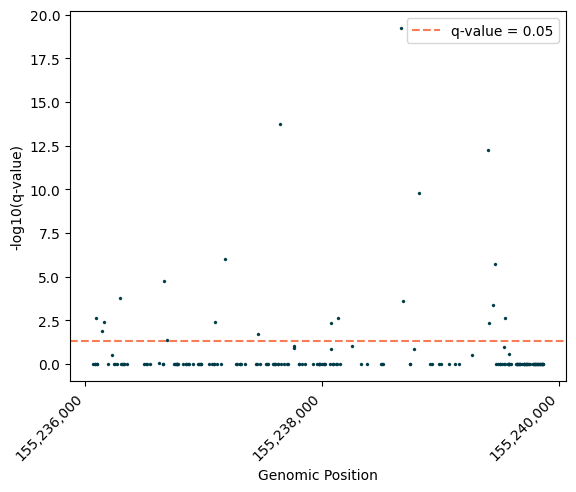

In [19]:
dmc_calls["minus_log10_qvalue"] = -np.log10(dmc_calls["dmr_qvalue"])
g = sns.scatterplot(
    data=dmc_calls, 
    x="Start", 
    y="minus_log10_qvalue",
    edgecolor=None,
    s=5,
)

# Format axis labels
plt.xlabel("Genomic Position")
plt.ylabel("-log10(q-value)")
# add significance threshold line
plt.axhline(-np.log10(0.05), color='C2', linestyle='--', label="q-value = 0.05")

# Format x-axis labels
ticks = g.get_xticks()
xlabels = ["{:,.0f}".format(x) for x in ticks]
g.set_xticklabels(xlabels)
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
# Only three ticks on x-axis
plt.locator_params(axis='x', nbins=3)
# Add legend
plt.legend()

plt.show()

## Volcano plot of DMRs

Now let's return to our region-based calls. Let's visualise the q-values of our DMR calls against the mean methylation difference between the two groups.

In [20]:
dmr_regions["dmr_qvalue"] = dmr_regions["dmr_qvalue"].replace(0, 10**-300)
dmr_regions["-log10 dmr_qvalue"] = -np.log10(dmr_regions["dmr_qvalue"])

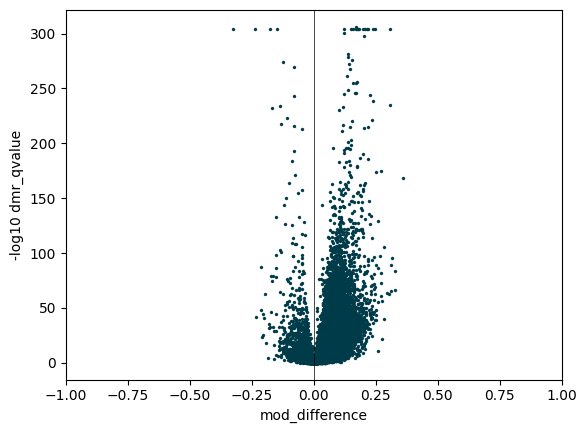

In [21]:
g = sns.scatterplot(
    x="mod_difference",
    y="-log10 dmr_qvalue",
    data=dmr_regions,
    edgecolor=None,
    s=5,
)
g.set_xlim(-1, 1)
g.axvline(0, color="black", linewidth=0.5)
g.axvline(np.log2(1./2), color="black", linewidth=0.5, linestyle="--")
g.axvline(np.log2(2.), color="black", linewidth=0.5, linestyle="--")

The solid black line marks the transition from hypo to hyper methylated DMRs. Hence the right-hand side of that line indicate DMRs where the Ashkenazi family is less methylated on average than the Han family.

## A closer look at some DMRs

Let's look at regions with low q-values, high number of CpGs, and significant methylation difference. These should be our strong DMR calls.

In [22]:
dmrs = dmr_regions.query(
    "dmr_qvalue < 0.01 & num_contexts > 10 & (mod_difference < -0.05 | mod_difference > 0.05)"
).reset_index(drop=True)
dmrs = dmrs.sort_values("dmr_pvalue")
dmrs

Chromosome      Start        End  num_contexts  mean_coverage  \
18059       chr1  244280325  244284050            63      96.089947   
241         chr1   23030631   23034399            35     106.876190   
18060       chr1  244284050  244287775            63      97.216931   
5223        chr1  143326766  143327537            84      48.507937   
165         chr1   16699390   16700179            89      81.932584   
...          ...        ...        ...           ...            ...   
4987        chr1  121627144  121627659            12      33.152778   
5427        chr1  149412235  149414853            20      39.116667   
5214        chr1  124807770  124808169            12      32.194444   
5105        chr1  123652048  123652730            11      42.515152   
5057        chr1  123112849  123113680            12      38.972222   

       mean_mod_group_1  mean_mod_group_2  mod_fold_change  mod_difference  \
18059          0.678418          0.849053         1.251519        0.170635   
241            0.550629          0.788732         1.432420        0.238103   
18060          0.646204          0.860158         1.331093        0.213954   
5223           0.733338          0.938419         1.279654        0.205081   
165            0.392937          0.155515         0.395776       -0.237422   
...                 ...               ...              ...             ...   
4987           0.724702          0.783422         1.081027        0.058720   
5427           0.679546          0.618624         0.910349       -0.060922   
5214           0.665899          0.719740         1.080855        0.053841   
5105           0.586700          0.643289         1.096452        0.056589   
5057           0.661589          0.609712         0.921587       -0.051877   

       test_statistic     dmr_pvalue     dmr_qvalue                     Slice  \
18059     1424.550130  9.720008e-312  6.357954e-307  chr1:244280325-244284050   
241       1415.936394  7.234870e-310  2.366200e-305    chr1:23030631-23034399   
18060     2122.689492  2.225074e-308  7.660227e-305  chr1:244284050-244287775   
5223      2150.004558  2.225074e-308  7.660227e-305  chr1:143326766-143327537   
165       3091.502387  2.225074e-308  7.660227e-305    chr1:16699390-16700179   
...               ...            ...            ...                       ...   
4987         8.732711   3.125514e-03   4.345043e-03  chr1:121627144-121627659   
5427         8.229197   4.122176e-03   5.666162e-03  chr1:149412235-149414853   
5214         7.787822   5.259957e-03   7.150764e-03  chr1:124807770-124808169   
5105         7.782403   5.275756e-03   7.171200e-03  chr1:123652048-123652730   
5057         7.263604   7.036594e-03   9.445130e-03  chr1:123112849-123113680   

       -log10 dmr_qvalue  
18059         306.196683  
241           304.625948  
18060         304.115758  
5223          304.115758  
165           304.115758  
...                  ...  
4987            2.362006  
5427            2.246711  
5214            2.145648  
5105            2.144408  
5057            2.024792  

[18301 rows x 14 columns]

We can use the [`plot_methylation_tile`](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.plot_methylation_tile) method of the [`ContigDataset`](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset) to plot visualise the DMRs. 

In the two examples below, we can see tiles where the methylation is different between HG002, HG003, HG004 (the Ashkenazi trio) on one hand and HG005, HG006, HG007 (the Han trio) on the other hand. Each patch of color is a CpG. The dark patches correspond to CpGs with high methyation fraction, while the light patches correpond to a low methylation fraction. Grey patches (if any) are CpGs with low coverage. For each panel, the bottom plot is a locator which shows the genomic location of each CpG.

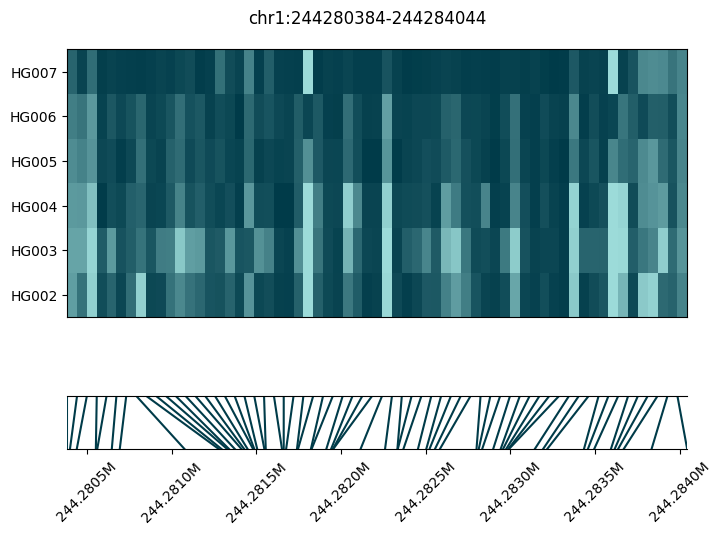

In [23]:
fig = substore[dmrs["Slice"].iloc[0]].plot_methylation_tile(
    numerator="num_modc",
    denominator="num_total_c",
    min_coverage=5,
)

We can also plot the [methylation trace](https://modality-docs.biomodal.com/modality.html#modality.contig_dataset.ContigDataset.plot_methylation_trace). It shows the methylation fraction across the region of interest. In our case, it clearly shows a distinct pattern of methylation between the Ashkenazi group (blue-ish colours) and the Han group (red-ish colours).

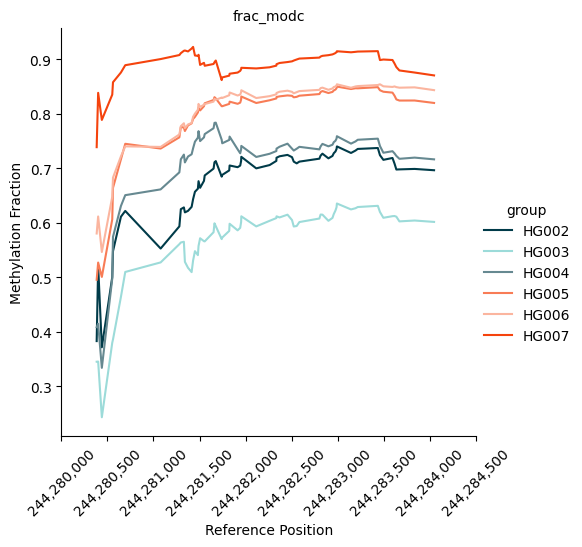

In [24]:
kwargs = {
    "palette": ["#003B49", "#9CDBD9", "#668991", "#F87C56", "#fbb59f", "#f5430d"],
}

fig = substore[dmrs["Slice"].iloc[0]].plot_methylation_trace(
    numerators=["num_modc"],
    denominator="num_total_c",
    min_coverage=5,
    **kwargs
)

Let's look at a second example:

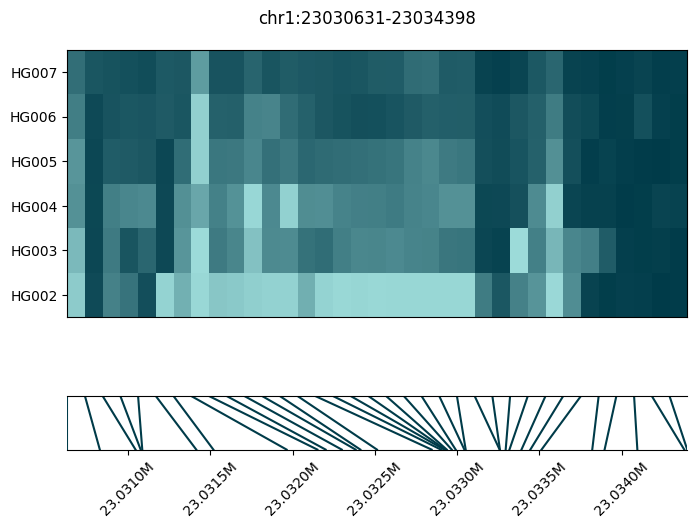

In [25]:
fig = substore[dmrs["Slice"].iloc[1]].plot_methylation_tile(
    numerator="num_modc",
    denominator="num_total_c",
    min_coverage=5,
)

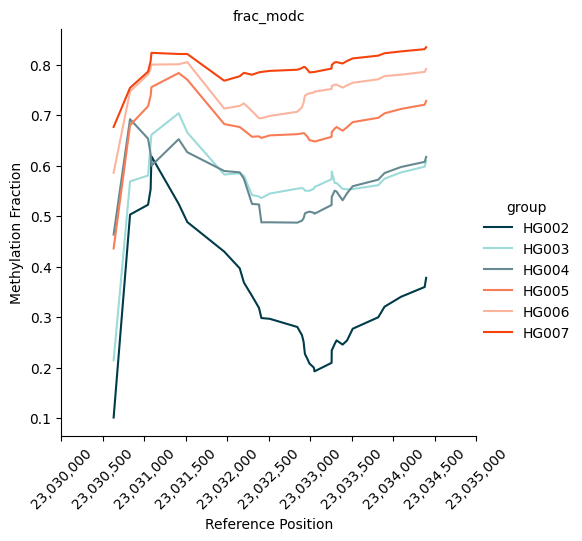

In [26]:
fig = substore[dmrs["Slice"].iloc[1]].plot_methylation_trace(
    numerators=["num_modc"],
    denominator="num_total_c",
    min_coverage=5,
    **kwargs
)

## A non-DMR example

In this example there is not clear difference in methylation between the two family trios, hence it was correctly not called as a DMR. 

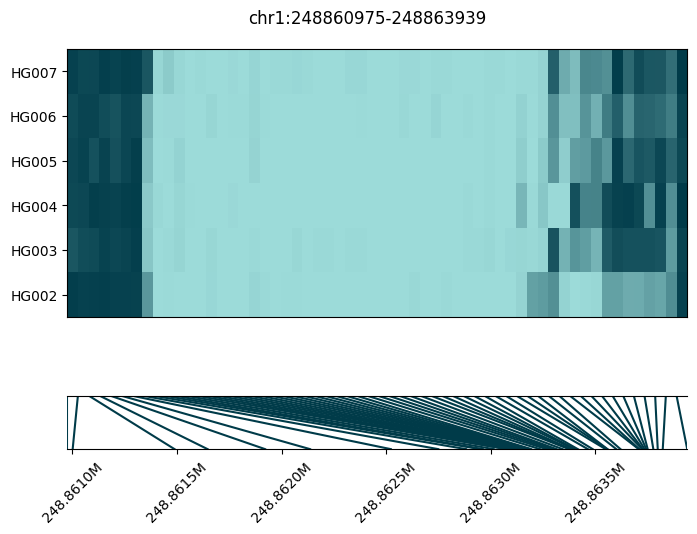

In [27]:
fig = substore[dmr_regions["Slice"].iloc[-7]].plot_methylation_tile(
    numerator="num_modc",
    denominator="num_total_c",
    min_coverage=5,
)

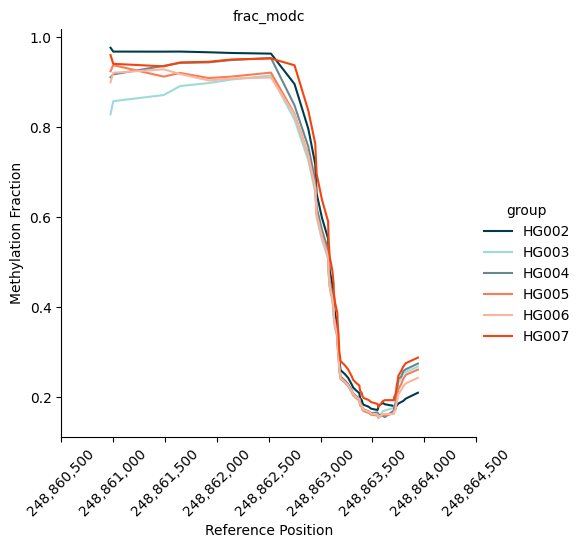

In [28]:
fig = substore[dmr_regions["Slice"].iloc[-7]].plot_methylation_trace(
    numerators=["num_modc"],
    denominator="num_total_c",
    min_coverage=5,
    **kwargs
)